# Toy Train
The toy-train has a rasberry-pi loaded on its trailer which collects the data. The data consists of the following attributes :
- Temperature of the raspberry pi
- Atmospheric pressure
- Humidity measure by a sense hat
- Pitch of the rasberry-pi (up/down)
- Roll of the rasberry-pi 
- Yaw of the rasberry-pi 
<img src="roll.jpg" alt="Describles what roll, pitch and yaw means with in terms of an aeroplane" title="Roll, Pitch, Yaw"/>
This image was taken from the website https://howthingsfly.si.edu/flight-dynamics/roll-pitch-and-yaw
This picture describes what roll , pitch and yaw means with respect to an aeroplane. THe roll, pitch and the yaw of the rasberry-pi in this problem is a similar estimate of the train's roll, pitch and yaw. The track of the train also consists of a bridge. 
## Dataset
The data is collected for 8 laps around the track. The values of the sensors are collected for every two seconds. Each lap has varying operatinal settings.
## Problem Definition
The goal of this task is to estimate the yaw of the rasberry pi 10 steps in the future. This gives us the estimate when the train is going to turn.

In [223]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [224]:
datasetLocation = 'toy-train.arff'
neuralNetworkLocation='neural_networkmodel.hdf5'
filenameRandomForestLag = 'best_model_random_forest.sav'
filenameRandomForestNoLag = 'finalized_model_random_forest.sav'
future = 10

In [225]:
def load_dataset(data_location):
    """
    Function to read dataset
    input : location of dataset
    output : a dataframe with dataset
    """
    data = arff.loadarff(data_location)
    framework = pd.DataFrame(data[0])
    return framework

In [226]:
dataFramework = load_dataset(datasetLocation)
dataFramework.head()

,temperature,pressure,humidity,gyro_pitch,gyro_roll,gyro_yaw
0,39.59,1017.30,22.54,2.83,1.26,210.09
1,39.81,1017.31,22.57,2.83,1.26,210.08
2,39.61,1017.31,22.93,2.83,1.26,210.12
3,39.74,1017.31,22.16,2.83,1.26,210.22
4,39.68,1017.32,22.69,2.84,1.26,210.27


Check for missing data

In [227]:
print(len(dataFramework))
print(dataFramework.isna().values.any())
print(dataFramework.isnull().values.any())
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

2335
False
False


## Target Label Addition to dataframe

In [228]:
def label_add(dataFramework,future):
    dataFramework['prediction']= np.nan
    dataFramework.head()
    for number, value in enumerate(dataFramework.values):
        dataFramework['prediction'][number]=dataFramework['gyro_yaw'][number+future]
        if number>=2334-10-1:
            break
    listToDrop= np.arange(2324,2335,1)
    dataFramework =dataFramework.drop(dataFramework.index[listToDrop])
    dataFramework.head()
    return dataFramework
dataFramework = label_add(dataFramework,future)
dataFramework.head()

,temperature,pressure,humidity,gyro_pitch,gyro_roll,gyro_yaw,prediction
0,39.59,1017.30,22.54,2.83,1.26,210.09,208.62
1,39.81,1017.31,22.57,2.83,1.26,210.08,207.59
2,39.61,1017.31,22.93,2.83,1.26,210.12,206.24
3,39.74,1017.31,22.16,2.83,1.26,210.22,204.92
4,39.68,1017.32,22.69,2.84,1.26,210.27,202.99


In [229]:
dataFramework[dataFramework.columns] = scaler.fit_transform(dataFramework[dataFramework.columns])
X= dataFramework[['temperature','pressure','humidity','gyro_pitch','gyro_roll','gyro_yaw']]
y = dataFramework[['prediction']]
print(dataFramework.isna().values.any())
print(dataFramework.isnull().values.any())

False
False


A grid search to search for the best model setting using a random forest regressor

In [98]:
## search for best random forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [10,20,30, 100,200],
    'max_features': ['auto', 'log2',None],
    'max_depth' : [4,5,6,7,8]
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column

/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/earl/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

In [17]:
def plot_mine(localArray,dataFramework):
    for number,name in enumerate(dataFramework.columns[:-1]):
        print('importance of '+ name+' is '+ str(localArray[number]))
    labels_plot = dataFramework.columns[:-1]
    plt.figure(figsize=(10, 12))
    plt.pie(localArray, startangle=90)
    plt.legend(labels_plot)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
def print_values(clf,X_test):
    y_pred = clf.predict(X_test)
    print("Accuracy:",metrics.r2_score(y_test, y_pred))
    print("Mean Squared Error:",metrics.mean_squared_error(y_test, y_pred))

/home/earl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.9560255398374136
importance of temperature is 0.006731336608699021
importance of pressure is 0.01429163036827607
importance of humidity is 0.0032201427772186493
importance of gyro_pitch is 0.014669489380283885
importance of gyro_roll is 0.02162745320615174
importance of gyro_yaw is 0.9394599476593707


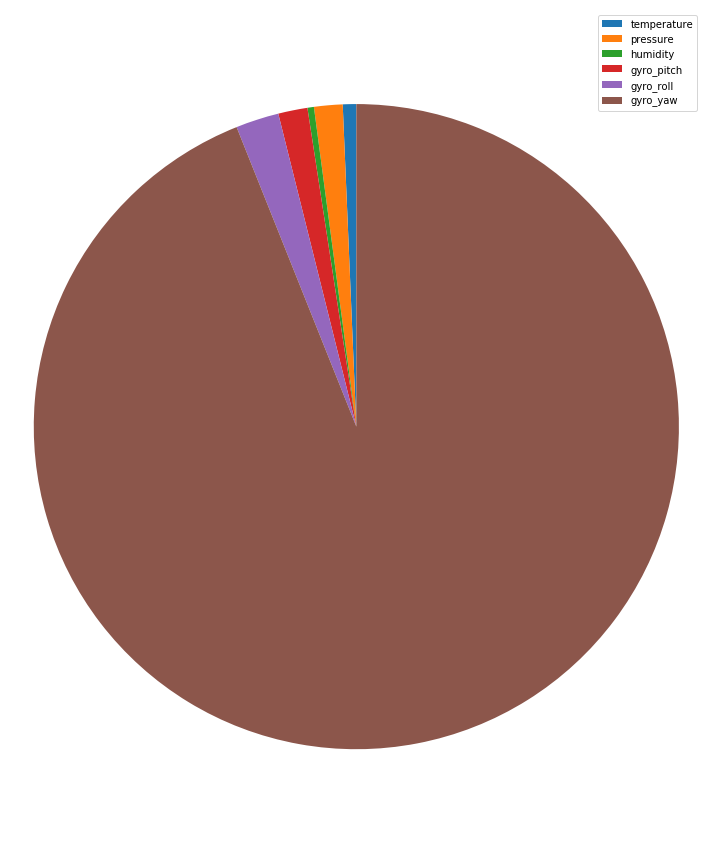

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = RandomForestRegressor(max_depth=8,max_features= 'auto',n_estimators=200)
clf.fit(X_train, y_train)
print_values(clf,X_test)
localArray=clf.feature_importances_
pickle.dump(clf, open(filenameRandomForestNoLag, 'wb'))
plot_mine(localArray,dataFramework)

The prediction is made with only one set of sensor values. But the prediction this problem is similar to a time series problem but for different laps. So I wanted to try a reccurrent neural networks which takes the values time steps and predicts the future

In [233]:
def create_dataset(dataFramework,lookback =1):    
    
    numberOfColumns = ((lookback+1)*(len(dataFramework.columns)-1))
    localList = np.arange(numberOfColumns+1)
    columnsNew=[]
    for i in localList:
        columnsNew.append(str(i))
    newFramework = pd.DataFrame([])
    for number, value in enumerate(dataFramework.values):
        if number <=lookback-1:
            continue
        else:
            localArray = np.array([])
            for i in range(number,number-lookback,-1):
                localValues = np.array(dataFramework.loc[number-lookback,:].values)[:-1]
                localArray = np.append(localArray,localValues)
            localArray= np.append(localArray,value)
            localSeries = pd.Series(localArray)        
            newFramework = newFramework.append(localSeries,ignore_index=True)
            
    return newFramework,columnsNew
lookback=20
framework,columnsOfFramework = create_dataset(dataFramework,lookback)  
        

In [234]:
xColumns = framework.columns[:-1]
yColumns = framework.columns[-1]
X= framework[xColumns]
y = framework[yColumns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
3
	
# reshape input to be 3D [samples, timesteps, features]

train_X =np.reshape(X_train.values.flatten(),(len(X_train.values),lookback+1,6))
test_X = X_test.values.reshape((X_test.values.shape[0], lookback+1, 6))
print(train_X.shape)
X =np.reshape(X.values.flatten(),(len(X.values),lookback+1,6))

(1612, 21, 6)


In [68]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, activation='relu',input_shape = (train_X.shape[1],train_X.shape[2])))
regressor.add(LSTM(units=50,activation='relu'))
regressor.add(Dense(units = 1,activation='relu'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
cb= [EarlyStopping(monitor='val_acc', min_delta=0.00001, patience=10, verbose=0,mode='min', baseline=None )]
regressor.fit(X,y,validation_split=0.30, epochs=200, batch_size=64,callbacks=cb)


Train on 1619 samples, validate on 695 samples
Epoch 1/200
1619/1619 [==============================] - 4s 2ms/step - loss: 0.1640 - val_loss: 0.0580
Epoch 2/200
 320/1619 [====>.........................] - ETA: 0s - loss: 0.0478

/home/earl/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1619/1619 [==============================] - 1s 476us/step - loss: 0.0387 - val_loss: 0.0329
Epoch 3/200
1619/1619 [==============================] - 1s 519us/step - loss: 0.0278 - val_loss: 0.0234
Epoch 4/200
1619/1619 [==============================] - 1s 542us/step - loss: 0.0253 - val_loss: 0.0221
Epoch 5/200
1619/1619 [==============================] - 1s 539us/step - loss: 0.0242 - val_loss: 0.0209
Epoch 6/200
1619/1619 [==============================] - 1s 546us/step - loss: 0.0241 - val_loss: 0.0216
Epoch 7/200
1619/1619 [==============================] - 1s 549us/step - loss: 0.0234 - val_loss: 0.0205
Epoch 8/200
1619/1619 [==============================] - 1s 552us/step - loss: 0.0230 - val_loss: 0.0229
Epoch 9/200
1619/1619 [==============================] - 1s 581us/step - loss: 0.0232 - val_loss: 0.0204
Epoch 10/200
1619/1619 [==============================] - 1s 561us/step - loss: 0.0227 - val_loss: 0.0209
Epoch 11/200
1619/1619 [==============================] - 1s 590us

KeyboardInterrupt: 

In [71]:
regressor.load_weights(neuralNetworkLocation)
print_values(regressor,test_X)

Accuracy: 0.9830756612804525
Error: 0.0013964091790983574


It is possible to get the important features of a Keras Regressor but I am not sure if there is a method to get the important features of an LSTM model

In [237]:
clf = RandomForestRegressor(max_depth=50,max_features= 'auto',n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pickle.dump(clf, open(filenameRandomForestLag, 'wb'))
print("Accuracy:",metrics.r2_score(y_test, y_pred))

Accuracy: 0.9956173867416355


In [209]:
def array_for_plot(classifier,dataFramework,lookback):
    localArray=classifier.feature_importances_
    localArray = np.reshape(localArray,(lookback+1,len(dataFramework.columns)-1))
    localArray = np.sum(localArray,axis=0)
    return localArray

importance of temperature is 0.0038286125137467057
importance of pressure is 0.002869369883701892
importance of humidity is 0.0009388644574126357
importance of gyro_pitch is 0.009459254413753787
importance of gyro_roll is 0.016913874272818128
importance of gyro_yaw is 0.965990024458567


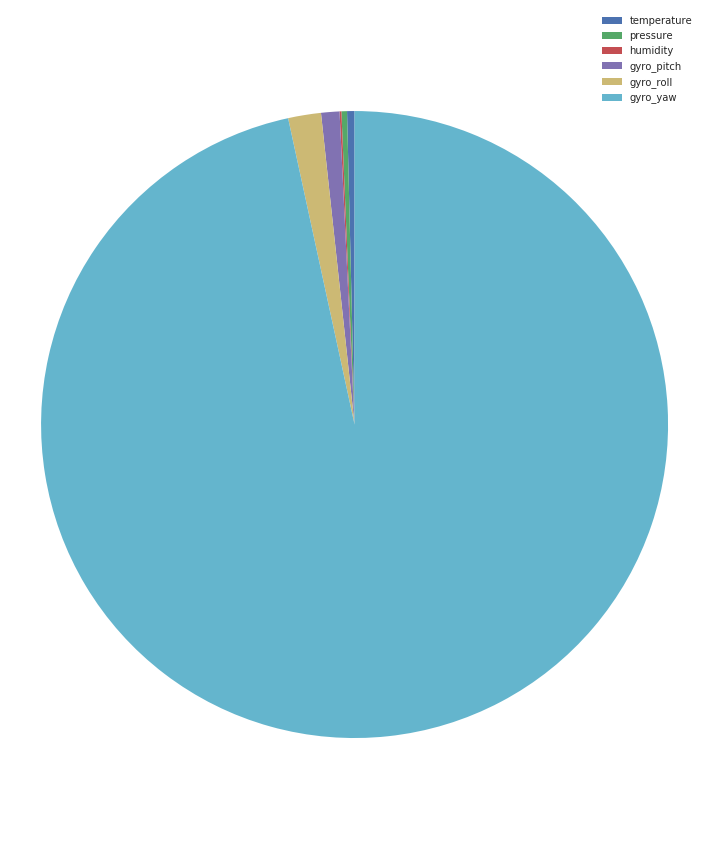

Accuracy: 0.9956173867416355
Error: 0.0003568442867766098


In [236]:
clf =pickle.load(open(filenameRandomForestLag, 'rb'))
localArray = array_for_plot(clf,dataFramework,lookback)
plot_mine(localArray,dataFramework)
print_values(clf,X_test)

Looks like the random forest model with 20 steps look back predicts with a slightly better accuracy when compared to the LSTM model. Would be a good to try find the best set of parameters for the random forest model. Si

In [219]:
dataFramework = load_dataset(datasetLocation)
dataFramework = label_add(dataFramework,future)
scaler = MinMaxScaler(feature_range=(0, 1))
checkForLap = False
counter = 0
lap = 0
counters =[]
for number,value in enumerate(dataFramework.values): 
    counter +=1
    if value[3]>4:
        checkForLap =True
    previousLap = lap
    if checkForLap:
        if value[3]<1 and abs(value[4]<1):
            counters.append(counter)
            previousCounter = counter
            counter=0
            lap+=1
            checkForLap = False
            
    if lap == 8 and number+1 == len(dataFramework):
        lastCounter = counter
        counters.append(counter)
        print(counters)
    if lap == 1 and previousLap == 0:
        firstCounter = previousCounter    

[86, 253, 258, 257, 261, 257, 292, 386, 274]


In [220]:
localArray = np.arange(firstCounter)
counterArray = np.cumsum(counters[1:])
dataFramework = dataFramework.drop(dataFramework.index[localArray])
dataFramework.reset_index(inplace=True)
dataFramework[dataFramework.columns] = scaler.fit_transform(dataFramework[dataFramework.columns])
dataFramework['lap'] = np.nan
lap = 0
for number, value in enumerate(dataFramework.values):
    if number == counterArray[lap]:
            lap+=1
    dataFramework['lap'][number]= lap
dataFramework = dataFramework[dataFramework.columns[1:]]

In [ ]:
clf=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [50,100,200,300],
    'max_features': ['auto', 'log2',None],
    'max_depth' : [8,10,15,20,50]
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_